# Preparación para el TF MDS+

## Exploración de los datos (EDA)

Repo para trabajo de preparación

Dataset: https://www.yelp.com/dataset/documentation/main

Extraer fotos del RAR en /dataset/photos.

Extraer archivo photos.json en /dataset

In [1]:
import pandas as pd
import pathlib
# pip install imageio==2.21.1
import imageio as iio
import numpy as np
import matplotlib.pyplot as plt
# pip install scikit-image==0.19.3
from skimage.color import rgb2gray
# pip install tqdm
from tqdm.notebook import trange, tqdm
import os
from matplotlib import image
import pickle
from sklearn.preprocessing import OneHotEncoder

## EDA del JSON

In [2]:
%%time
df = pd.read_json(r'dataset/photos.json', lines=True)

CPU times: user 408 ms, sys: 87.3 ms, total: 496 ms
Wall time: 701 ms


In [3]:
df.head()

,photo_id,business_id,caption,label
0,zsvj7vloL4L5jhYyPIuVwg,Nk-SJhPlDBkAZvfsADtccA,Nice rock artwork everywhere and craploads of ...,inside
1,HCUdRJHHm_e0OCTlZetGLg,yVZtL5MmrpiivyCIrVkGgA,,outside
2,vkr8T0scuJmGVvN2HJelEA,_ab50qdWOk0DdB6XOrBitw,oyster shooter,drink
3,pve7D6NUrafHW3EAORubyw,SZU9c8V2GuREDN5KgyHFJw,Shrimp scampi,food
4,H52Er-uBg6rNrHcReWTD2w,Gzur0f0XMkrVxIwYJvOt2g,,food


No vamos usar 'business_id' ni 'caption' en el trabajo

In [4]:
df = df.drop(columns = ['business_id', 'caption'])
df.head(2)

,photo_id,label
0,zsvj7vloL4L5jhYyPIuVwg,inside
1,HCUdRJHHm_e0OCTlZetGLg,outside


In [5]:
df.shape

(200100, 2)

In [6]:
df.describe()

,photo_id,label
count,200100,200100
unique,200098,5
top,_CYoxbCIKuAwpq4crHCPWg,food
freq,2,108152


In [7]:
df.label.value_counts()

food       108152
inside      56031
outside     18569
drink       15670
menu         1678
Name: label, dtype: int64

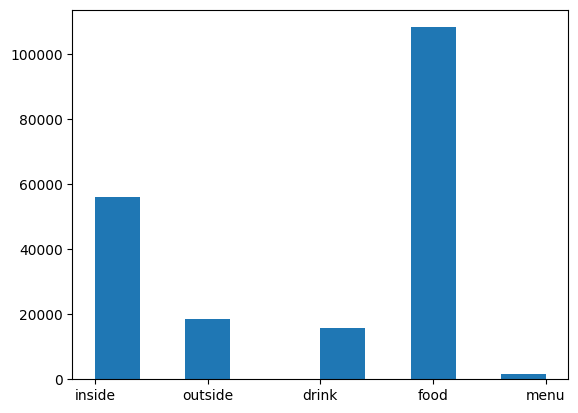

In [8]:
plt.hist(df.label);

Hay pocas fotos de 'menu'

In [9]:
df.photo_id.value_counts().max()

2

Hay fotos con dos etiquetas (labels)

In [10]:
df.photo_id.value_counts().nlargest(n=3)

_CYoxbCIKuAwpq4crHCPWg    2
qtl5YDIc2q0yelW_e9FfqQ    2
zsvj7vloL4L5jhYyPIuVwg    1
Name: photo_id, dtype: int64

Solo hay dos fotos que tienen dos etiquetas.

In [11]:
df[df.photo_id == '_CYoxbCIKuAwpq4crHCPWg']

,photo_id,label
29695,_CYoxbCIKuAwpq4crHCPWg,inside
174504,_CYoxbCIKuAwpq4crHCPWg,drink


In [12]:
df[df.photo_id == 'qtl5YDIc2q0yelW_e9FfqQ']

,photo_id,label
173977,qtl5YDIc2q0yelW_e9FfqQ,inside
188850,qtl5YDIc2q0yelW_e9FfqQ,food


## EDA de las fotos

In [13]:
%%time
img_path = 'dataset/photos/'
lista = os.listdir(img_path)

CPU times: user 17.3 ms, sys: 19.1 ms, total: 36.4 ms
Wall time: 35.9 ms


In [15]:
pickle.dump(lista, open('checkpoints/lista.pkl', 'wb'))

In [16]:
# checkpoint
lista = pd.read_pickle('checkpoints/lista.pkl')

In [17]:
example_photo_name = lista[0]
example_photo_index = df[df.photo_id == example_photo_name[:-4]].index[0]
im = iio.v3.imread('dataset/photos/'+example_photo_name)

In [18]:
im.shape

(400, 300, 3)

Photo: --0h6FMC0V8aMtKQylojEg.jpg   Tag: inside


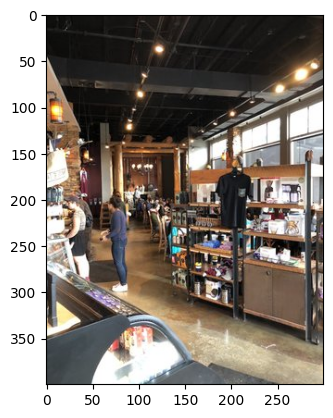

In [19]:
plt.imshow(im);
print('Photo: {}   Tag: {}'.format(example_photo_name,
                                   df.loc[df.photo_id == example_photo_name[:-4],
                                          'label'][example_photo_index]))

In [20]:
# Convertir en gris
im_gray = rgb2gray(im)

In [21]:
im_gray.shape

(400, 300)

Photo: --0h6FMC0V8aMtKQylojEg.jpg   Tag: inside


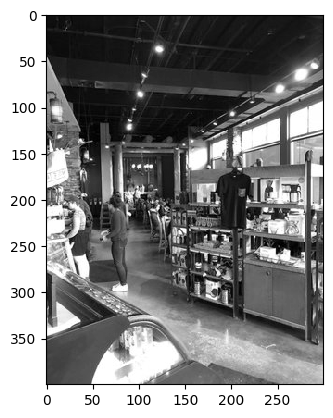

In [22]:
plt.imshow(im_gray, cmap='gray', interpolation='nearest');
print('Photo: {}   Tag: {}'.format(example_photo_name, 
                                   df.loc[df.photo_id == example_photo_name[:-4], 
                                          'label'][example_photo_index]))

Convertir en gris reduce la información a procesar a un tercio. Si el coste de entrenar el modelo es muy alto, se probará con la versión gris de las imagenes.

Vamos comprobar si las imagenes tienen distintos tamaños y si son todas validas.

In [23]:
%%time
photo_counter = 0
photo_data =[]

for img in tqdm(df.photo_id, desc='Photos processed', miniters=500):
    try:
        shape = image.imread('dataset/photos/'+img+'.jpg').shape
        photo_data.append([img,          # photo_id
                    shape[0],            # x_dim
                    shape[1],            # y_dim
                    shape[2],            # z_channels
                    shape[0] * shape[1], # pixels
                    False])              # corrupt
    except:
        # file is corrupt
        photo_data.append([img,         # photo_id
                           np.nan,      # x_dim
                           np.nan,      # y_dim
                           np.nan,      # z_channels
                           np.nan,      # pixels
                           True])       # corrupt

Photos processed:   0%|          | 0/200100 [00:00<?, ?it/s]

CPU times: user 11min 52s, sys: 1min 3s, total: 12min 55s
Wall time: 27min 48s


In [24]:
df2 = pd.DataFrame(photo_data, columns=['photo_id',
                                        'x_dim', 
                                        'y_dim', 
                                        'z_channels', 
                                        'pixels', 
                                        'corrupt'])

In [25]:
df2.head()

,photo_id,x_dim,y_dim,z_channels,pixels,corrupt
0,zsvj7vloL4L5jhYyPIuVwg,400.0,225.0,3.0,90000.0,False
1,HCUdRJHHm_e0OCTlZetGLg,400.0,533.0,3.0,213200.0,False
2,vkr8T0scuJmGVvN2HJelEA,400.0,600.0,3.0,240000.0,False
3,pve7D6NUrafHW3EAORubyw,400.0,600.0,3.0,240000.0,False
4,H52Er-uBg6rNrHcReWTD2w,400.0,600.0,3.0,240000.0,False


In [26]:
pickle.dump(df2, open("checkpoints/df2.pkl", "wb"))

In [27]:
# checkpoint
df2 = pickle.load(open('checkpoints/df2.pkl','rb'))

In [28]:
print('El dataset tiene {} imagenes validas y {} imagenes corruptas.'.format(len(df2[df2.corrupt == False]),len(df2[df2.corrupt == True])))
print('El tamaño de las imagenes en el eje x está entre {} y {} pixeles'.format(df2.x_dim.min(),df2.x_dim.max()))
print('El tamaño de las imagenes en el eje y está entre {} y {} pixeles'.format(df2.y_dim.min(),df2.y_dim.max()))
print('El número de canales está entre {} y {}'.format(df2.z_channels.min(),df2.z_channels.max()))
print('La resolución de las imagenes varia entre {} y {} miles de pixels'.format(df2.pixels.min()/1000, df2.pixels.max()/1000))

El dataset tiene 199994 imagenes validas y 106 imagenes corruptas.
El tamaño de las imagenes en el eje x está entre 62.0 y 400.0 pixeles
El tamaño de las imagenes en el eje y está entre 49.0 y 600.0 pixeles
El número de canales está entre 3.0 y 3.0
La resolución de las imagenes varia entre 5.625 y 240.0 miles de pixels


Vamos crear un dataframe que tenga las etiquetas y los datos de las imagenes.

In [29]:
df3 = df.set_index('photo_id').join(df2.set_index('photo_id'), how="inner")#.drop('index', axis=1)

In [30]:
df3.head()

,label,x_dim,y_dim,z_channels,pixels,corrupt
photo_id,,,,,,
--0h6FMC0V8aMtKQylojEg,inside,400.0,300.0,3.0,120000.0,False
--3JQ4MlO-jHT9xbo7liug,food,400.0,400.0,3.0,160000.0,False
--3P3fjPrScy06XVLi4vhg,inside,400.0,560.0,3.0,224000.0,False
--4DfhW2sJvjeC90KEDX3g,inside,400.0,300.0,3.0,120000.0,False
--5V3mRlhb3zqE5yF4Gpaw,inside,400.0,300.0,3.0,120000.0,False


In [31]:
pickle.dump(df3, open("checkpoints/df3.pkl", "wb"))

In [32]:
# checkpoint
df3 = pickle.load(open('checkpoints/df3.pkl','rb'))

Vamos analizar de la distribución de fotos por tipo.

In [33]:
enc = OneHotEncoder(sparse=False, drop=None)
enc.fit(df3[['label']])
df4 = df3.copy()
df4 = df4.reset_index()
df4[enc.categories_[0]] = pd.DataFrame(enc.transform(df4[['label']]))
df4.head()

,photo_id,label,x_dim,y_dim,z_channels,pixels,corrupt,drink,food,inside,menu,outside
0,--0h6FMC0V8aMtKQylojEg,inside,400.0,300.0,3.0,120000.0,False,0.0,0.0,1.0,0.0,0.0
1,--3JQ4MlO-jHT9xbo7liug,food,400.0,400.0,3.0,160000.0,False,0.0,1.0,0.0,0.0,0.0
2,--3P3fjPrScy06XVLi4vhg,inside,400.0,560.0,3.0,224000.0,False,0.0,0.0,1.0,0.0,0.0
3,--4DfhW2sJvjeC90KEDX3g,inside,400.0,300.0,3.0,120000.0,False,0.0,0.0,1.0,0.0,0.0
4,--5V3mRlhb3zqE5yF4Gpaw,inside,400.0,300.0,3.0,120000.0,False,0.0,0.0,1.0,0.0,0.0


In [34]:
pickle.dump(df4, open('checkpoints/df4.pkl','wb'))

In [35]:
# checkpoint
df4 = pickle.load(open('checkpoints/df4.pkl','rb'))

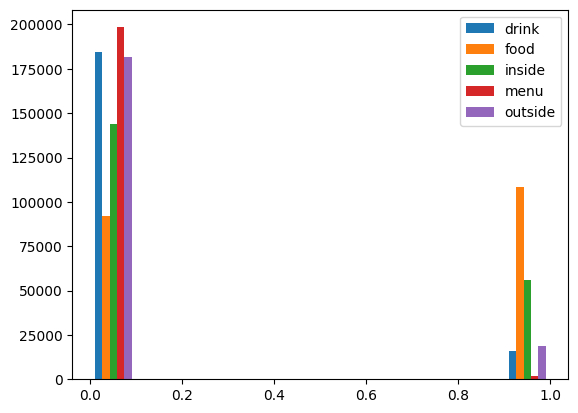

In [36]:
plt.hist(df4[['drink', 'food', 'inside', 'menu', 'outside']]);
plt.legend(['drink', 'food', 'inside', 'menu', 'outside'])

Miremos la foto mas grande.

photo_id      --Oz_XBrbYJa1RgEfo6Msw
label                           food
x_dim                          400.0
y_dim                          600.0
z_channels                       3.0
pixels                      240000.0
Name: 24, dtype: object

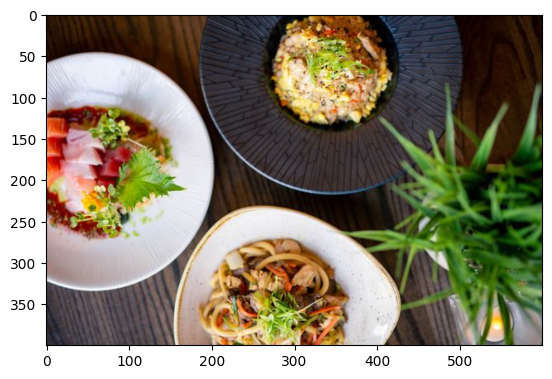

In [37]:
largest_photo = df4.iloc[df4.loc[df4.pixels == df4.pixels.max()].index[0],0]
im = iio.v3.imread('dataset/photos/'+largest_photo+'.jpg')
plt.imshow(im);
df4.iloc[df4.loc[df4.pixels == df4.pixels.max()].index[0], 0:6]

...y la mas pequeña.

photo_id      WVFbs0CLGDM1y_Ff0_zRIQ
label                           food
x_dim                           75.0
y_dim                           75.0
z_channels                       3.0
pixels                        5625.0
Name: 104955, dtype: object

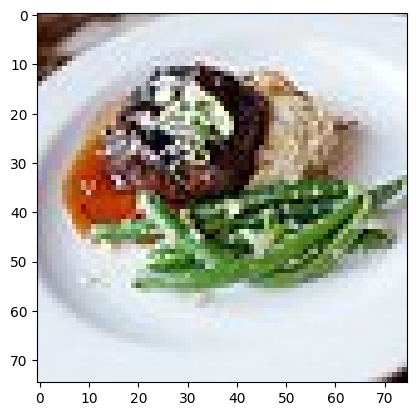

In [38]:
smallest_photo = df4.iloc[df4.loc[df4.pixels == df4.pixels.min()].index[0],0]
im = iio.v3.imread('dataset/photos/'+smallest_photo+'.jpg')
plt.imshow(im);
df4.iloc[df4.loc[df4.pixels == df4.pixels.min()].index[0], 0:6]

Miremos la distribución de las fotos en función de su tamaño.

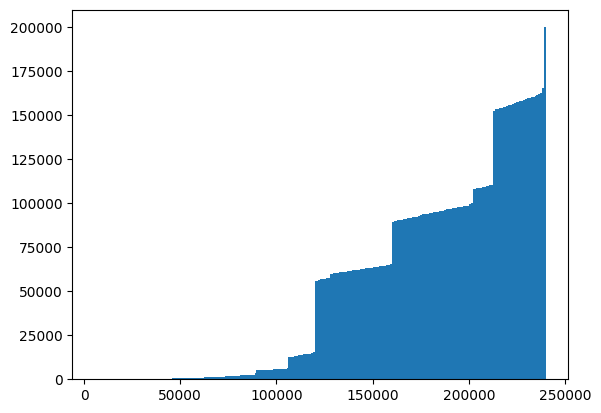

In [39]:
plt.hist(df4.pixels.dropna(), bins=240, cumulative=True);

Hay relativamente pocas fotos con menos de 100 mil pixeles.

Miremos el impacto de desechar las que tengan menos de 224 pixeles en cualquier dimensión.

In [40]:
df5 = df4.loc[df4.x_dim > 224].loc[df4.y_dim > 224]
df5.shape

(196660, 12)

food       106262
inside      55214
outside     18189
drink       15412
menu         1583
Name: label, dtype: int64

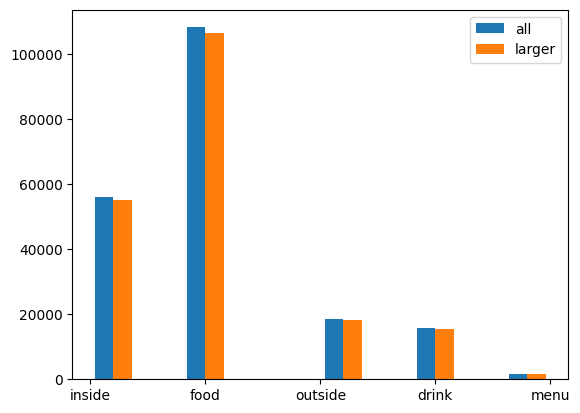

In [41]:
plt.hist([df4.label, df5.label]);
plt.legend(['all','larger'])
df5.label.value_counts()

No hay problema si no utilizamos las fotos pequeñas.

In [42]:
df5 = df5.drop('corrupt', axis=1)

In [43]:
pickle.dump(df5,open('checkpoints/df5.pkl','wb'))

# Conclusiones

1. Todas las imagenes son en color (tienen 3 canales)
2. Practicamente todas las fotos tienen solo una etiqueta
3. La llave se llama 'photo_id' y no tiene extensión
4. Hay 199.992 fotos validas
5. Las imagenes tienen distintos tamaños.
     - En vertical varian entre 62 y 400 pixeles
     - En horizontal varian entre 49 y 600 pixeles
6. Si solo utilizamos fotos > 224 pixeles en ambas dimensiones nos quedamos con 196.660
    - food : 106.262
    - inside : 55.214
    - outside : 18.189
    - drink : 15.412
    - menu : 1.583